In [1]:
import optuna
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Optuna を用いた最適化

In [2]:
fruits_data = {
    'mango': {
        'cost': 129.168,
        'calories': 61,
        'protein': 0.5,
        'fat': 0,
        'carbs': 14.2,
        'fiber': 0.9,
        'salt': 0.0
    },
    'blueberries': {
        'cost': 200.16,
        'calories': 54.666666666666664,
        'protein': 0.5333333333333333,
        'fat': 0,
        'carbs': 12.0,
        'fiber': 2.3333333333333335,
        'salt': 0.0
    },
    'strawberries': {
        'cost': 185.76,
        'calories': 34,
        'protein': 0.9,
        'fat': 0.1,
        'carbs': 7.1,
        'fiber': 1.4,
        'salt': 0.0
    },
    'pineapple': {
        'cost': 142.56,
        'calories': 56.666666666666664,
        'protein': 0.6,
        'fat': 0,
        'carbs': 13.0,
        'fiber': 1.2,
        'salt': 0.0
    }
}

n_trials = 1000

# protein vs calories

In [5]:
# 目的関数の定義
def objective_protein_calories(trial):
    # 各フルーツの重量を提案
    weights = {
        'mango': trial.suggest_int('mango', 0, 50),
        'blueberries': trial.suggest_int('blueberries', 0, 50),
        'strawberries': trial.suggest_int('strawberries', 0, 50),
        'pineapple': trial.suggest_int('pineapple', 0, 50)
    }
    
    # 合計コストとカロリーを計算
    total_protein = sum(weights[fruit] * fruits_data[fruit]['protein'] for fruit in weights) / 100
    total_calories = sum(weights[fruit] * fruits_data[fruit]['calories'] for fruit in weights) / 100
    
    return total_protein, total_calories

In [6]:
# Optuna による多目的最適化
study = optuna.create_study(directions=['maximize', 'minimize'])
study.optimize(objective_protein_calories, n_trials)

[I 2024-04-29 02:08:32,098] A new study created in memory with name: no-name-78c6542a-e161-48b4-8cc4-895d9850330d
[I 2024-04-29 02:08:32,104] Trial 0 finished with values: [0.31666666666666665, 27.999999999999996] and parameters: {'mango': 16, 'blueberries': 23, 'strawberries': 10, 'pineapple': 4}. 
[I 2024-04-29 02:08:32,107] Trial 1 finished with values: [0.7426666666666667, 52.54333333333333] and parameters: {'mango': 15, 'blueberries': 29, 'strawberries': 41, 'pineapple': 24}. 
[I 2024-04-29 02:08:32,110] Trial 2 finished with values: [0.6653333333333333, 48.16333333333333] and parameters: {'mango': 19, 'blueberries': 13, 'strawberries': 35, 'pineapple': 31}. 
[I 2024-04-29 02:08:32,113] Trial 3 finished with values: [0.3476666666666667, 35.94333333333333] and parameters: {'mango': 21, 'blueberries': 5, 'strawberries': 0, 'pineapple': 36}. 
[I 2024-04-29 02:08:32,115] Trial 4 finished with values: [0.6149999999999999, 43.33333333333333] and parameters: {'mango': 2, 'blueberries': 4

In [35]:
# 各試行の支配ランクを計算する関数
def calculate_dominance_ranks(trials):
    n = len(trials)
    dominated_counts = np.zeros(n)
    for i in range(n):
        for j in range(n):
            if i != j:
                # iがjに支配されているかどうかを確認
                if (trials[i].values[0] <= trials[j].values[0] and trials[i].values[1] >= trials[j].values[1]):
                    dominated_counts[i] += 1
    return dominated_counts

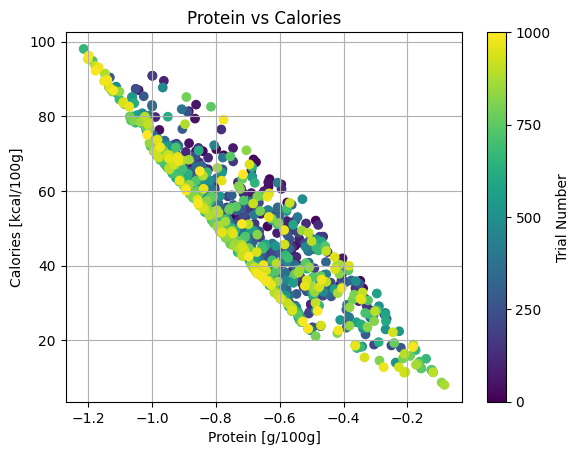

In [36]:
# パレートフロンティアの可視化部分を修正
protein = [-trial.values[0] for trial in study.trials]
calories = [trial.values[1] for trial in study.trials]

colors = [cm.viridis(i / n_trials) for i in range(n_trials)]

# プロットの設定
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(protein, calories, c=colors)
ax.set_title('Protein vs Calories')
ax.set_xlabel('Protein [g/100g]')
ax.set_ylabel('Calories [kcal/100g]')
ax.grid(True)

norm = plt.Normalize(0, n_trials)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Trial Number')
cbar.set_ticks(np.linspace(0, n_trials, num=5))  # 試行数に応じた目盛り
cbar.set_ticklabels([f'{int(n_trials * 0)}', f'{int(n_trials * 0.25)}', f'{int(n_trials * 0.5)}', f'{int(n_trials * 0.75)}', f'{n_trials}'])  # 目盛りのラベル

plt.show()

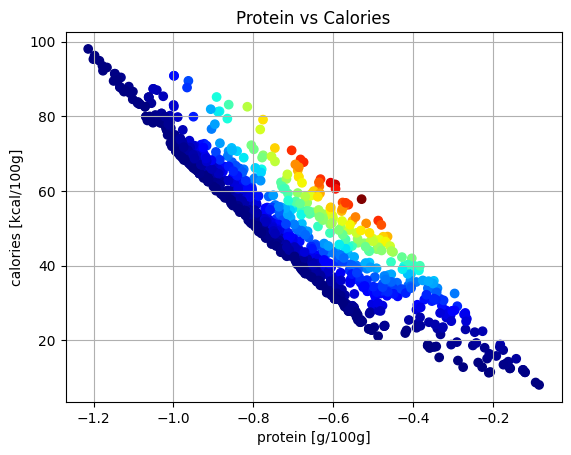

In [37]:
# 支配ランクの計算
dominance_ranks = calculate_dominance_ranks(study.trials)

# 支配ランクに基づいて色を割り当てる
colors = plt.cm.jet(dominance_ranks / np.max(dominance_ranks))

# カロリーとコストの値を取得
calories = [-trial.values[0] for trial in study.trials]
costs = [trial.values[1] for trial in study.trials]

# プロットの設定
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(calories, costs, c=colors)
ax.set_title('Protein vs Calories')
ax.set_xlabel('protein [g/100g]')
ax.set_ylabel('calories [kcal/100g]')
ax.grid(True)

plt.show()

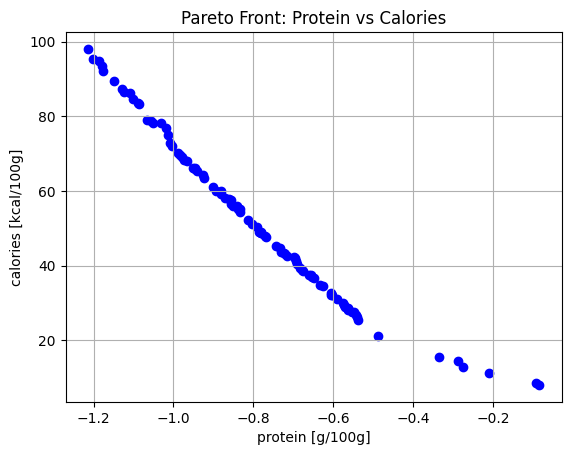

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

dominance_ranks = calculate_dominance_ranks(study.trials)
pareto_front_indices = np.where(dominance_ranks == 0)[0]
pareto_front_protein = [-study.trials[i].values[0] for i in pareto_front_indices]
pareto_front_calories = [study.trials[i].values[1] for i in pareto_front_indices]
ax.scatter(pareto_front_protein, pareto_front_calories, color='blue')
ax.set_title('Pareto Front: Protein vs Calories')
ax.set_xlabel('protein [g/100g]')
ax.set_ylabel('calories [kcal/100g]')
ax.grid(True)

plt.show()

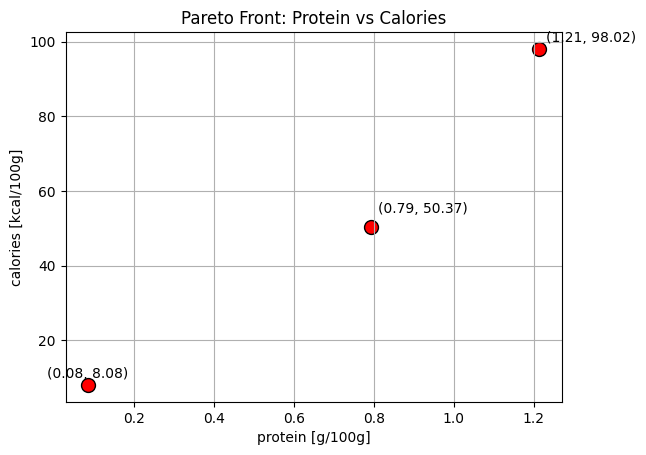

In [74]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

pareto_front_sorted = sorted(pareto_front_trials, key=lambda t: t.values[0])
first_trial = pareto_front_sorted[0]
last_trial = pareto_front_sorted[-1]
middle_trial = pareto_front_sorted[len(pareto_front_sorted) // 2]

# 注釈のためのオフセット値
offset = {'left': (-30, 5), 'right': (5, 5), 'top': (5, 10), 'bottom': (5, -20)}
selected_trials = [first_trial, last_trial, middle_trial]

# 選択された試行をプロットするためのコード
for i, trial in enumerate(selected_trials):
    x = trial.values[0]
    y = trial.values[1]
    # プロットに試行を追加
    plt.scatter(x, y, color='red', edgecolor='black', s=100)
    # 注釈のオフセット位置を決定
    if i == 0:  # 最初の試行（左端）
        xytext = offset['left']
    elif i == 1:  # 最後の試行（右端）
        xytext = offset['right']
    else:  # 中間の試行
        xytext = offset['top']
    # 各試行の目的関数の値をテキストとしてプロット上に表示
    ax.annotate(f'({x:.2f}, {y:.2f})', xy=(x, y), xytext=xytext, textcoords='offset points')


ax.set_title('Pareto Front: Protein vs Calories')
ax.set_xlabel('protein [g/100g]')
ax.set_ylabel('calories [kcal/100g]')
ax.grid(True)

plt.show()

In [73]:
for i in range(len(selected_trials)):
    param = selected_trials[i].params
    protein = sum(param[key] * fruits_data[key]['protein'] for key in param.keys()) / 100 
    calories = sum(param[key] * fruits_data[key]['calories'] for key in param.keys()) / 100 

    print(param)
    print(f'{protein=}', f'{calories=}')

{'mango': 1, 'blueberries': 12, 'strawberries': 1, 'pineapple': 1}
protein=0.084 calories=8.076666666666666
{'mango': 49, 'blueberries': 50, 'strawberries': 50, 'pineapple': 42}
protein=1.2136666666666667 calories=98.02333333333333
{'mango': 4, 'blueberries': 12, 'strawberries': 50, 'pineapple': 43}
protein=0.792 calories=50.36666666666666
